In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
# from RKHS import SparseVFC
# from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

2.3.1+cpu
None
False
0


In [10]:
data_path = 'data/'
data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
method = ''

result_path = 'DTW_action_results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

In [11]:
gene_arr=adata0.var.index.values
X_pca=adata0.obsm['X_pca']
X_umap=adata0.obsm['X_umap']
cell_vpt=adata0.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
Xs=adata0.layers['Ms']#adata.X.A#
X_pca.shape

(3184, 50)

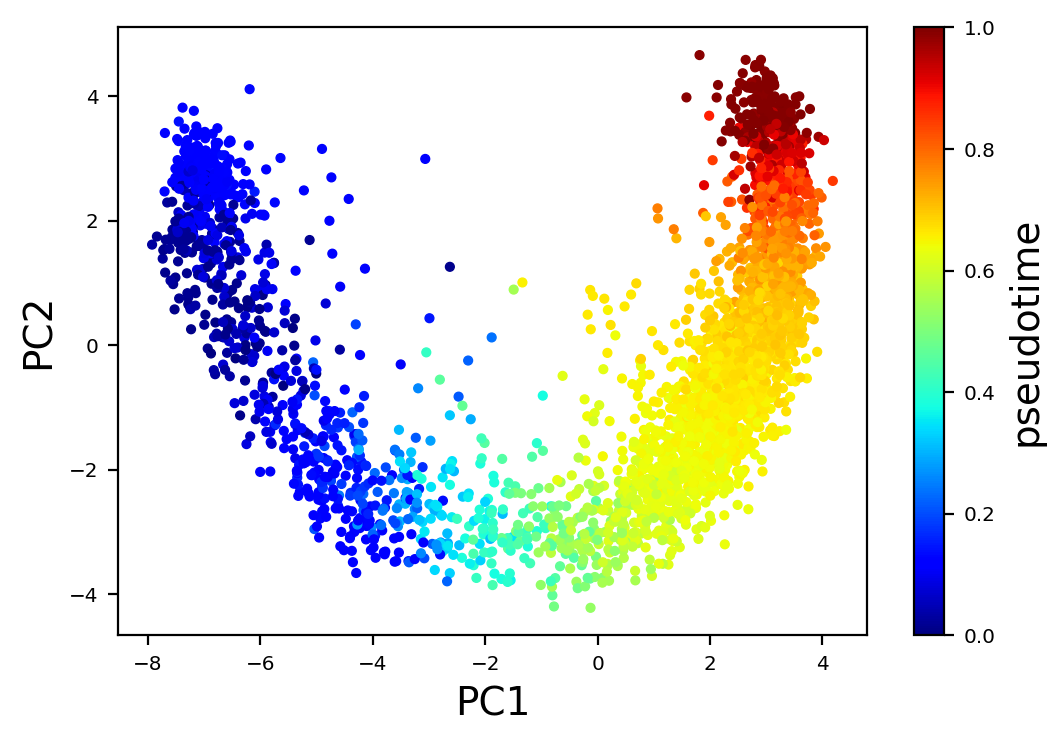

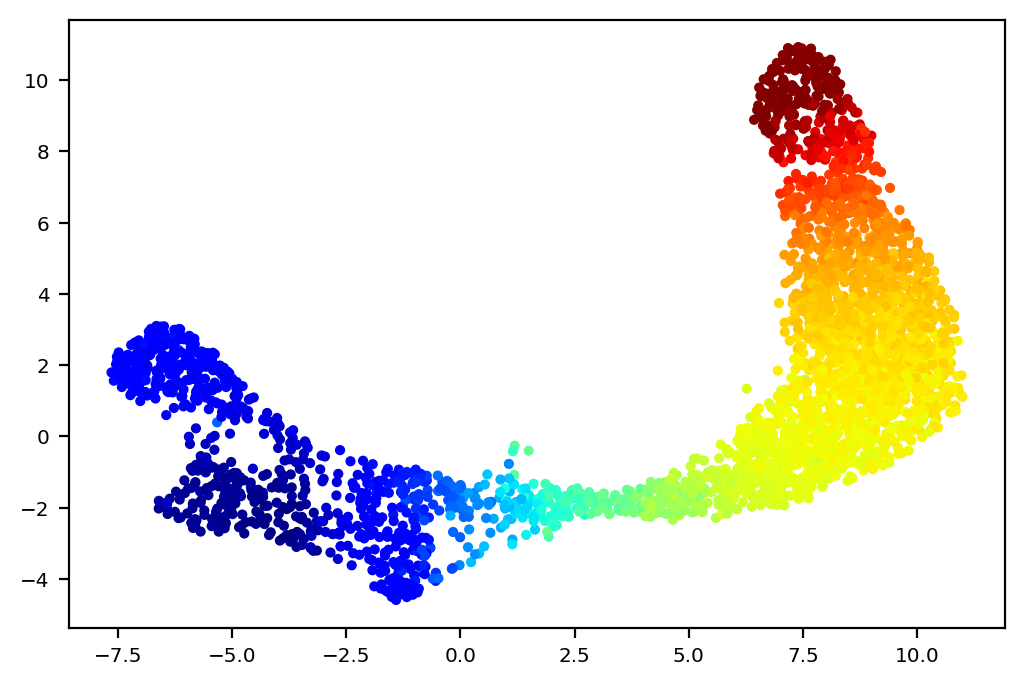

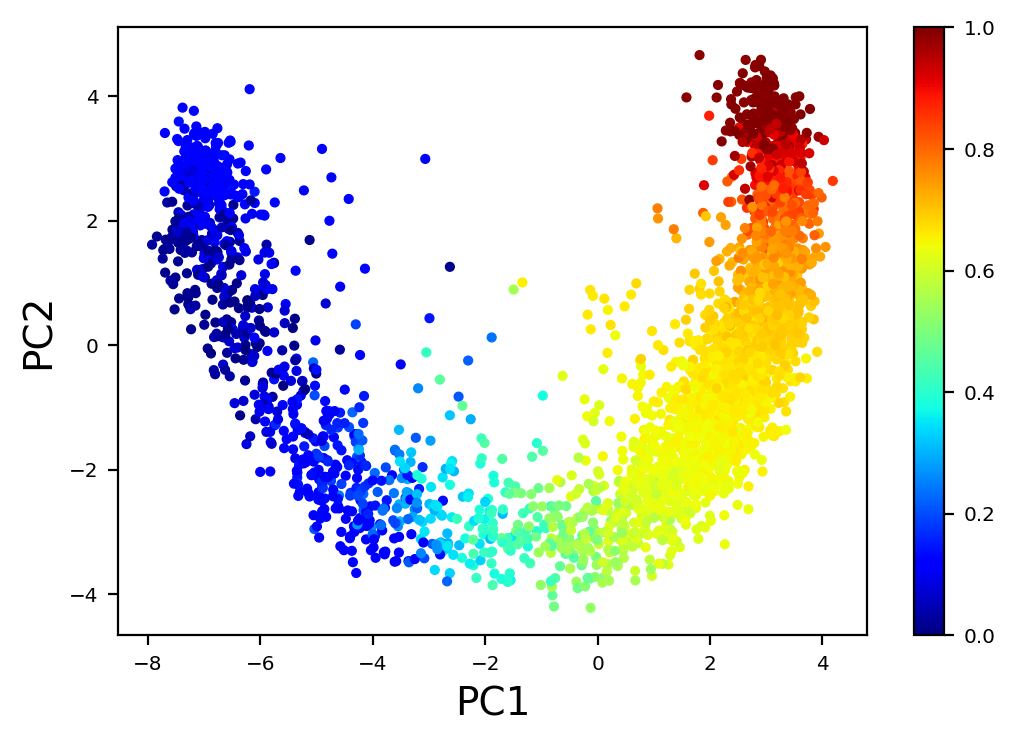

In [12]:
plt.scatter(X_pca[:,0],X_pca[:,1],s=10,c=cell_vpt,cmap=plt.cm.jet)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
clb=plt.colorbar()


clb.ax.set_ylabel('pseudotime',fontsize=14)

plt.savefig(result_path+'EG_vpt.png',dpi=300)
plt.show()

plt.scatter(X_umap[:,0],X_umap[:,1],s=10,c=cell_vpt,cmap=plt.cm.jet)
plt.show()


plt.scatter(X_pca[:,0],X_pca[:,1],s=10,c=cell_vpt,cmap=plt.cm.jet)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
clb=plt.colorbar()
plt.show()

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


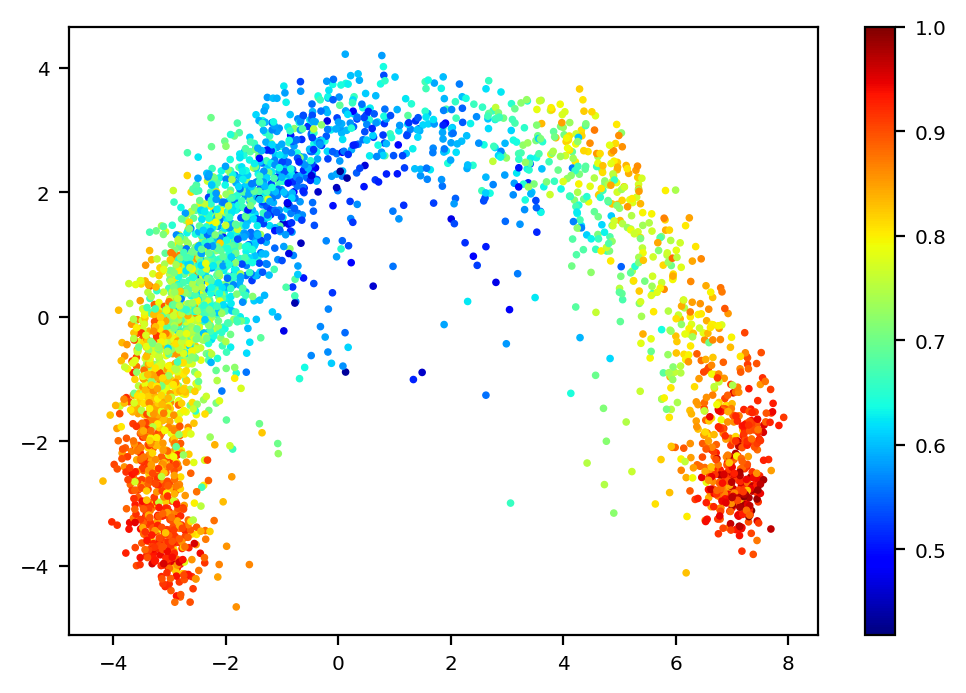

In [13]:
#-------data preprocessing
import scanpy as sc
k_nei=10
adata=adata0.copy()
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=k_nei+1)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)
scv.tl.velocity(adata)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
Xs = adata.layers['Ms'] #adata.X.A#
# Xs = adata.layers['M_s'] #如果是EG_ab_dyn
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])
cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
plt.colorbar()
plt.show()


def smooth_func(X_val,cell_nei,nei_w):
    X_sm=X_val.copy()
    for ci in range(len(X_val)):
        X_sm[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_sm

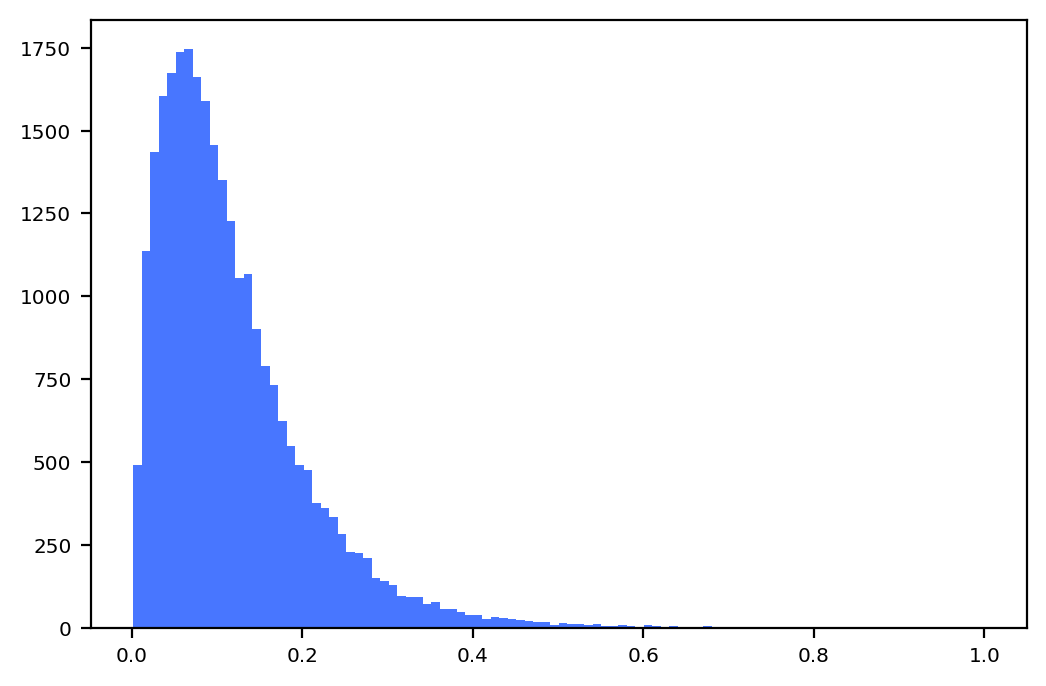

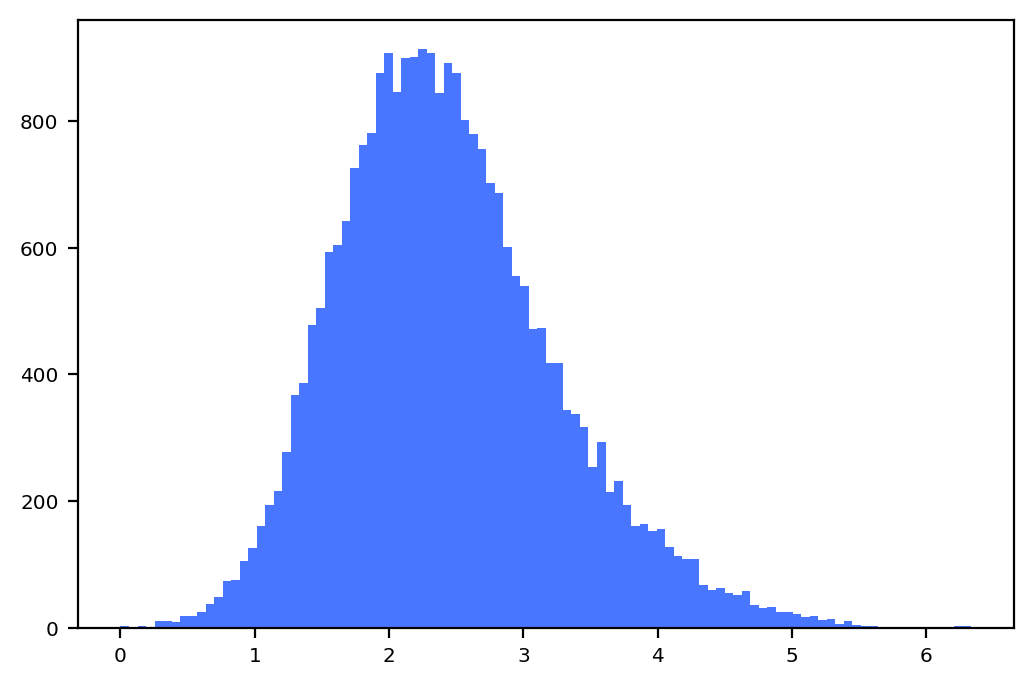

27221

In [14]:
Trans=scv.utils.get_transition_matrix(adata,weight_diffusion=0,self_transitions=False,weight_indirect_neighbors=0,n_neighbors=10,perc=10)#sum of each row is 1
plt.hist(Trans.data,bins=100)
plt.show()
# Trans.data[Trans.data<0.01]=1e-20
# Trans.data=-np.log(Trans.data)
plt.hist(-np.log(Trans.data),bins=100)
plt.show()
Trans.count_nonzero()

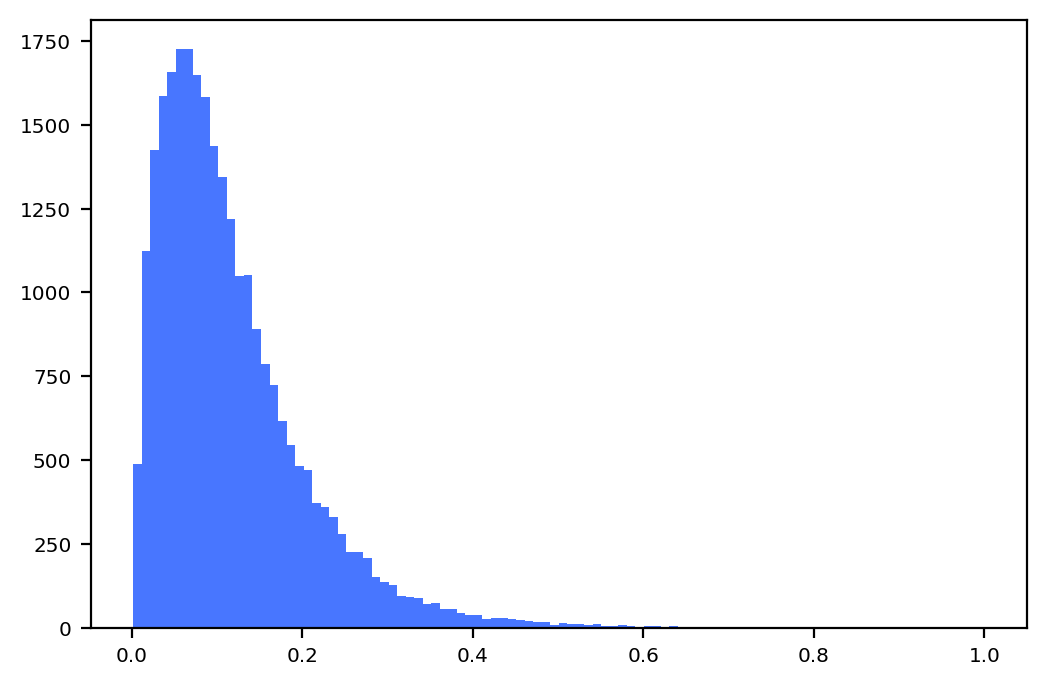

26969

In [15]:
from scipy import sparse
t_list=['RadialGlia','nIPC','Nbl1','Nbl2', 'ImmGranule1', 'ImmGranule2','Granule']

for t1 in range(len(t_list)):
    t1_inds=np.where(np.array(adata.obs['ClusterName'])==t_list[t1])[0]
    for i in t1_inds:
        mask=np.zeros(Trans.data[Trans.indptr[i]:Trans.indptr[i+1]].shape)
        col_inds=Trans.indices[Trans.indptr[i]:Trans.indptr[i+1]]
        for t2 in range(max(0,t1-1),min(t1+2,len(t_list))):
#             print(t_list[t2])
            t2_inds=np.where(np.array(adata.obs['ClusterName'])==t_list[t2])[0]
            mask+=np.in1d(col_inds,t2_inds).astype(np.int16)
        Trans.data[Trans.indptr[i]:Trans.indptr[i+1]][mask==0]=0
        
Trans= sparse.csr_matrix(Trans)
Trans.eliminate_zeros()
plt.hist(Trans.data,bins=100)
plt.show()
Trans.count_nonzero()

In [16]:
adata.obsp['transition_matrix']=Trans

In [17]:
# adata.uns['velocity_graph']=adata.obsp['transition_matrix']
# t_list=['RadialGlia','nIPC','Nbl1','Nbl2', 'ImmGranule1', 'ImmGranule2','Granule']

In [18]:
source_mean=np.mean(adata[(adata.obs['ClusterName']==t_list[0]),:].obsm['X_pca'],axis=0)
# target_mean=np.mean(adata[(adata.obs['ClusterName']==t_list[-1]),:].obsm['X_pca'],axis=0)
snodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-source_mean,axis=1))[:200]
# tnodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-target_mean,axis=1))[:50]

In [19]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)

In [143]:
dwell_thres=10
traj_arrs=[]
traj_seri=[]
adata_arrs=[]
for sn in snodes:
#     traj=scv.utils.get_cell_transitions(adata, starting_cell=sn, n_steps=600, basis='pca').T
    traj_ind=scv.utils.get_cell_transitions(adata, starting_cell=sn, n_steps=200)
    traj_t=np.array(adata[traj_ind,:].obs['ClusterName'].values)
    if len(np.where(traj_t==t_list[-1])[0])>0:
        F_arrs=consecutive_arrs(np.where(traj_t==t_list[-1])[0])
        end_t=0
        n=len(F_arrs)
        while n>=1:
            if F_arrs[n-1].shape[0]>dwell_thres:
                end_t=F_arrs[n-1][0]
                break
            n-=1

        if end_t>0:
            traj_seri.append(traj_ind[:end_t])

            traj=np.array(adata[traj_ind[:end_t],:].obsm['X_pca'])



            traj_arrs.append(traj)
            adata_traj=adata[traj_ind[:end_t],:]
            adata_arrs.append(adata_traj)

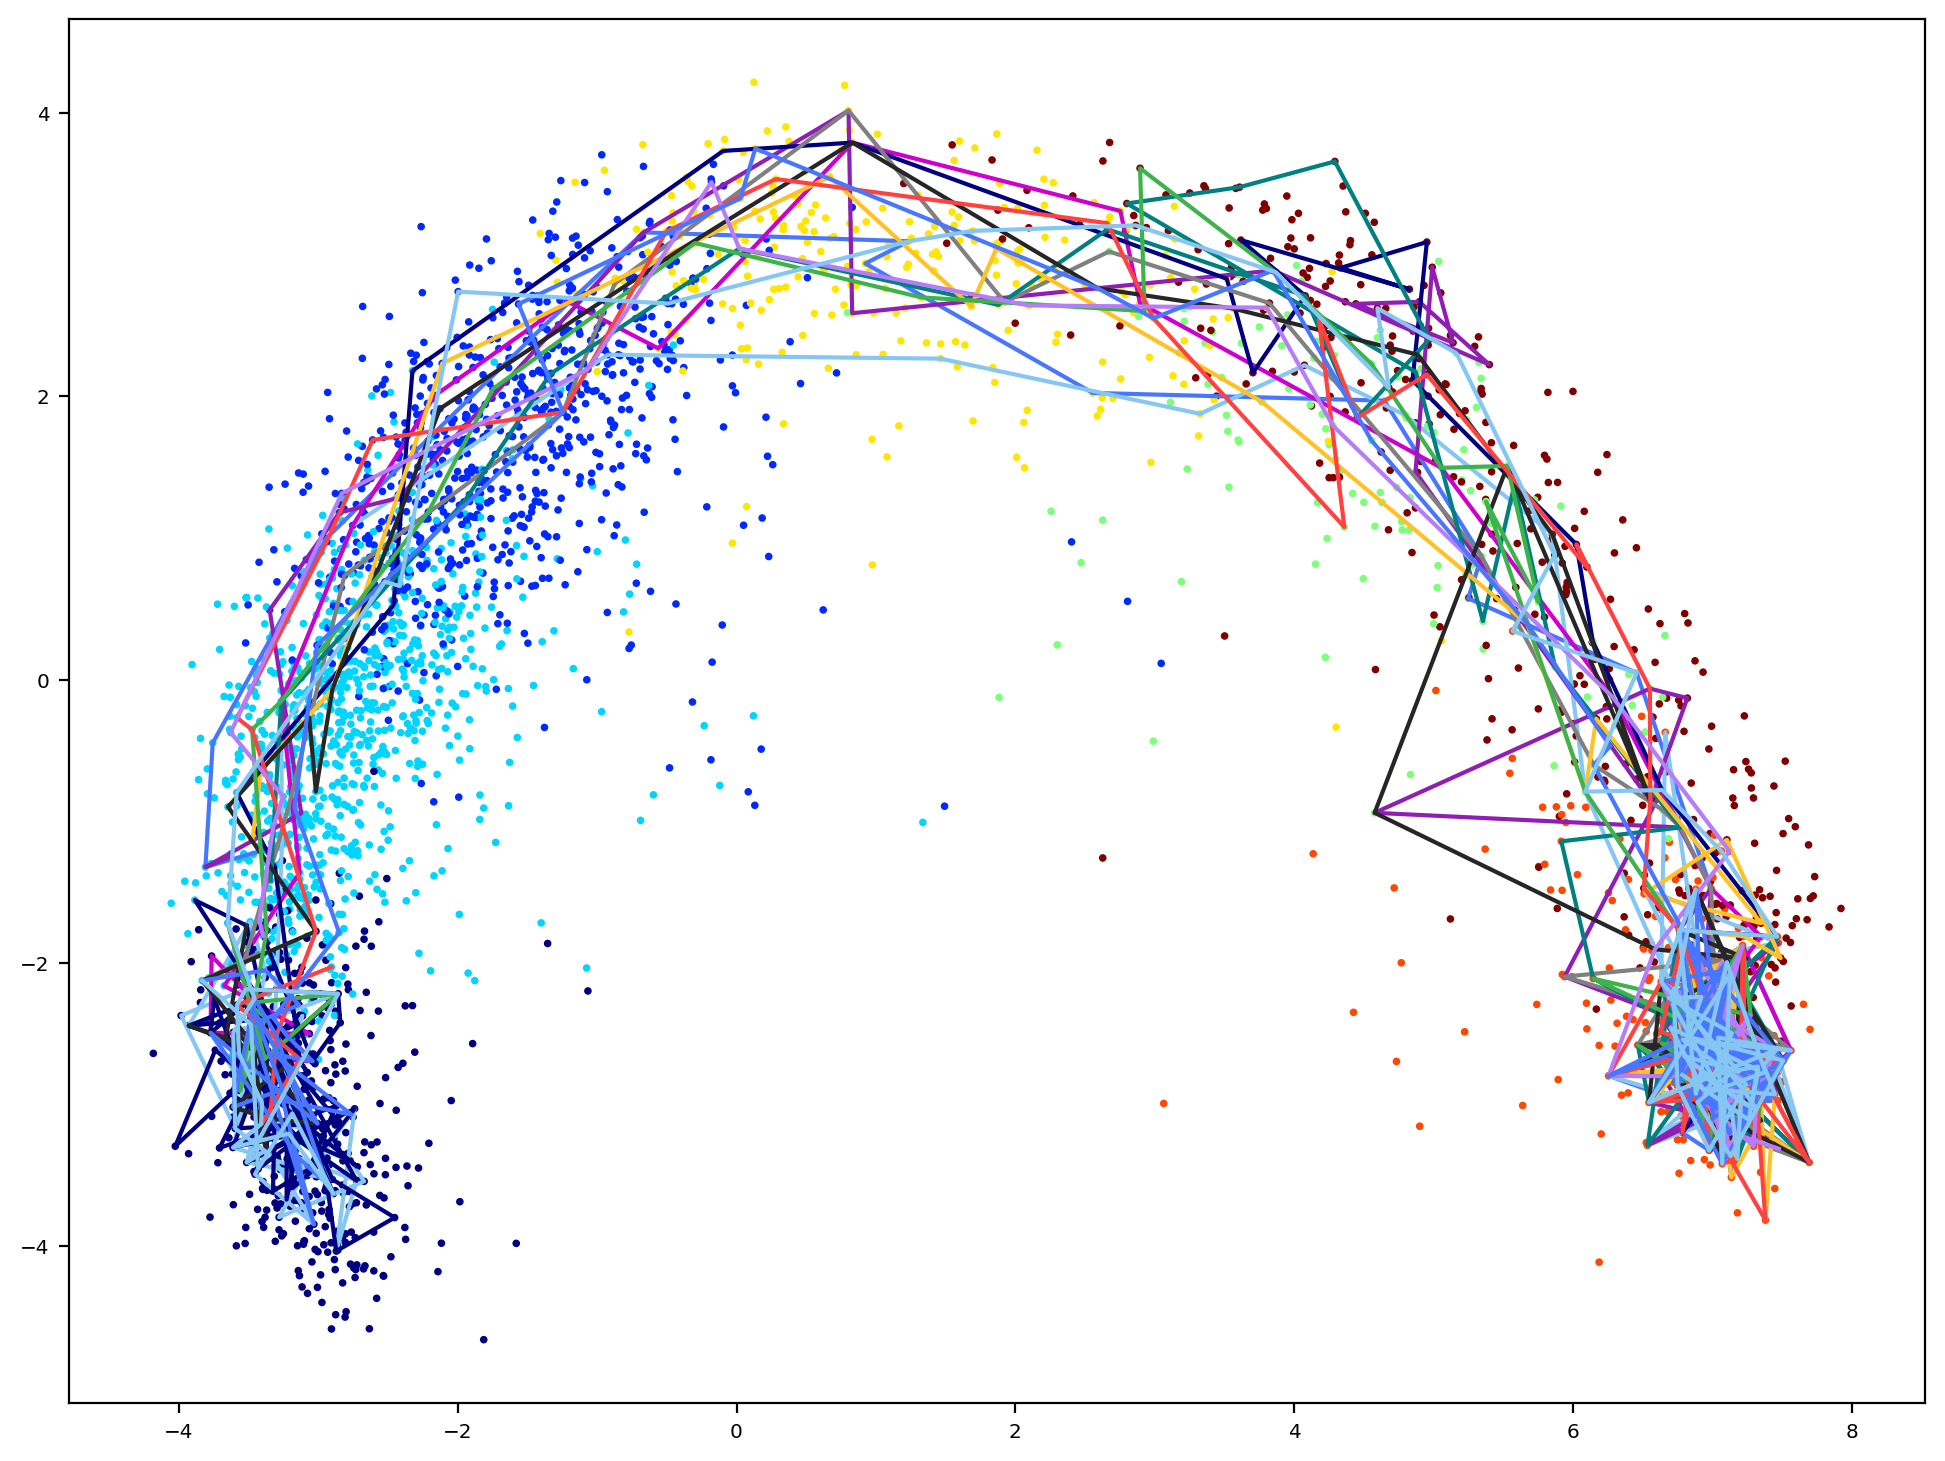

In [144]:
fig,ax=plt.subplots(figsize=(11.9,9.1))

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=np.unique(adata.obs['ClusterName'], return_inverse=True)[1],cmap='jet')
for i in range(len(traj_arrs)):
    
    plt.plot(traj_arrs[i][:,0],traj_arrs[i][:,1])
plt.show()

In [225]:
from tslearn.barycenters import dtw_barycenter_averaging,softdtw_barycenter
# average_path = dtw_barycenter_averaging(traj_arrs,barycenter_size=100)
average_path = softdtw_barycenter(traj_arrs, gamma=5)

In [226]:
average_path.shape

(112, 50)

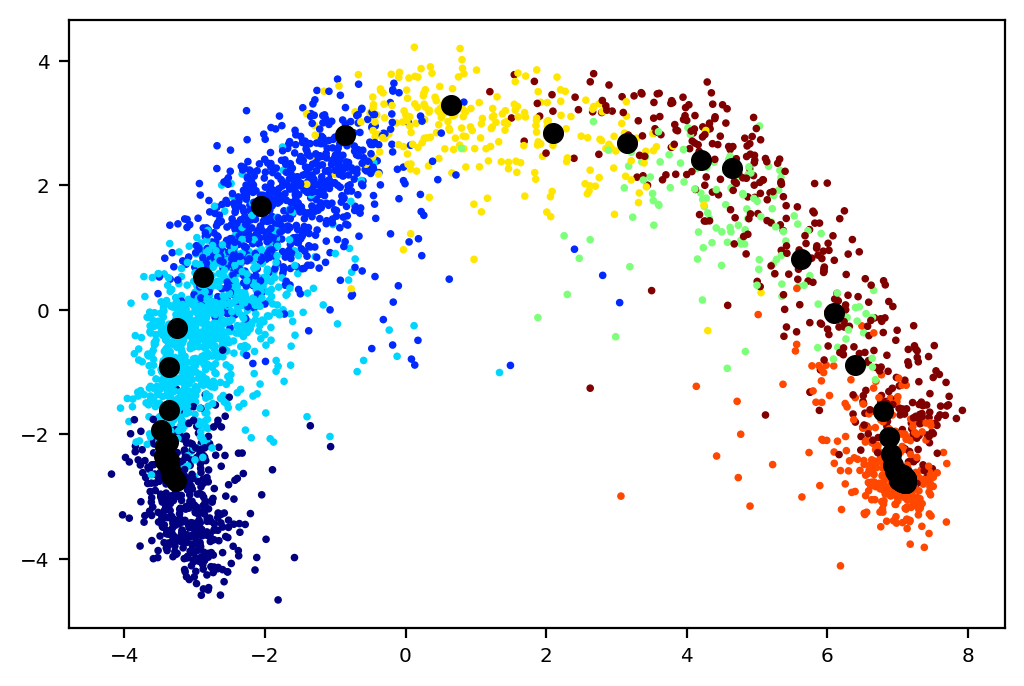

In [227]:
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=np.unique(adata.obs['ClusterName'], return_inverse=True)[1],cmap='jet')
plt.scatter(average_path[:,0],average_path[:,1],s=50, c='k')
# plt.plot(average_path[:,0],average_path[:,1])
plt.show()

## **计算离每个中心最近的那个cell属于哪个cluster，把第一个和最后一个cluster只留下一个中心** ##

In [228]:
# trans coordinates in average_path to nodes indices
distances = np.linalg.norm(X_pca[:, np.newaxis,:10] - average_path[:,:10], axis=2)

nearest_indices = np.argmin(distances, axis=0)

In [229]:
unique_arr, indices = np.unique(nearest_indices, return_index=True)
sorted_unique_arr = unique_arr[np.argsort(indices)]

In [230]:
average_path_truncated = []
for ind in sorted_unique_arr:
    if np.sum(nearest_indices == ind) == 1:
        average_path_truncated.append(average_path[np.where(nearest_indices == ind),:][0,0,:])
    else:
        average_path_truncated.append(np.mean(average_path[np.where(nearest_indices == ind),:], axis=1)[0,:])
average_path_truncated = np.array(average_path_truncated)
average_path_truncated.shape

(25, 50)

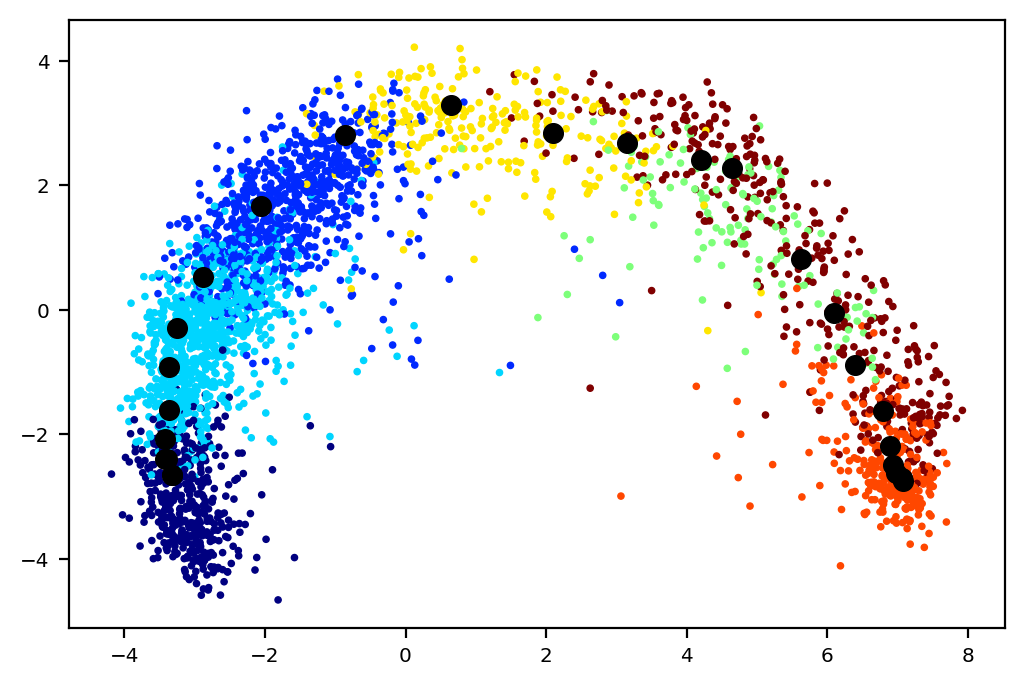

In [231]:
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=np.unique(adata.obs['ClusterName'], return_inverse=True)[1],cmap='jet')
plt.scatter(average_path_truncated[:,0],average_path_truncated[:,1],s=50,c='k')
# plt.plot(average_path[:,0],average_path[:,1])
plt.show()

In [232]:
np.save(result_path+'average_path.npy', average_path_truncated)